# 02 - Data from the Web

In this homework we will extract interesting information from [www.topuniversities.com](http://www.topuniversities.com) and [www.timeshighereducation.com](http://www.timeshighereducation.com), two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so we scrape the information we need. To understand how the server loads it in the browser, we used Postman with the Interceptor extension.

* [Task 1 - Scrape the QS ranking](#Task-1---Scrape-the-QS-ranking)
    * [Best universities for ratio between faculty members and students](#Which-are-the-best-universities-in-term-of-ratio-between-faculty-members-and-students-according-to-QS?)
    * [Best universities for the international students ratio](#Which-are-the-best-universities-in-term-of-ratio-of-international-students-according-to-QS?)
    * [Results by region](#Plot-the-results-from-QS-ranking-aggregating-by-region)
    * [Results by country](#Plot-the-results-from-QS-ranking-aggregating-by-country)


* [Task 2 - Scrape the Times ranking](#Task-2---Scrape-the-Times-ranking)
    * [Best universities for ratio between faculty members and students](#Which-are-the-best-universities-in-term-of-ratio-between-faculty-members-and-students-according-to-Times?)
    * [Best universities for the international students ratio](#Which-are-the-best-universities-in-term-of-ratio-of-international-students-according-to-Times?)
    * [Results by region](#Plot-the-results-from-Times-ranking-aggregating-by-region)
    * [Results by country](#Plot-the-results-from-Times-ranking-aggregating-by-country)
    
    
* [Task 3 - Merge the dataframes](#Task-3---Merge-the-dataframes)


* [Task 4 - Exploratory analysis](#Task-4---Exploratory-analysis)


* [Task 5 - Exploratory analysis](#Task-5--)

# Imports

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np
import string
import re
import pickle
import requests

pd.options.mode.chained_assignment = None
%matplotlib inline

# Constants definition

In [2]:
COLUMN_RANK = 'Rank'
COLUMN_UNIVERSITY_NAME = 'University Name'
COLUMN_REGION = 'Region'
COLUMN_COUNTRY = 'Country'
COLUMN_TOTAL_STUDENTS = 'Total Students'
COLUMN_INTERNATIONAL_STUDENTS = 'Total International Students'
COLUMN_TOTAL_FACULTY = 'Total Faculty'
COLUMN_INTERNATIONAL_FACULTY = 'Total International Faculty'
COLUMN_INTERNATIONAL_RATIO = 'Total International Students / Total Students'
COLUMN_FACULTY_RATIO = 'Total Faculty / Total Student'

In [3]:
QS_RANKING_JSON = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508104120137'
TIMES_RANKING_JSON = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [4]:
SEARCH_REFERENCE_API = 'https://en.wikipedia.org/w/api.php?action=query&titles={0}&prop=revisions&rvprop=content&format=json&indexpageids'

During the very first scraping of the QS ranking, we build a dataframe that contains the region for each country. This information will be used to fill in the region column in the Times dataframe.

After the first scraping is done, the three dataframes - containing the regions for each country and the two rankings - are serialized in local for future runs.

In [5]:
try:
    COUNTRY_REGION_METADATA = pd.read_pickle('serial/country_region_metadata.p')
except (OSError, IOError) as e:
    COUNTRY_REGION_METADATA = pd.DataFrame(columns=[COLUMN_REGION])
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')

Sample of the country-region dataframe:

In [6]:
COUNTRY_REGION_METADATA.head()

,Region
United States,North America
United Kingdom,Europe
Switzerland,Europe
Singapore,Asia
Australia,Oceania


# General use functions definition

We define some helper functions that will be used in the upcoming tasks.

In [7]:
def clean_str_number(str_n):
    """Obtain a string that only contains the numeric information, 
    dropping any formatting character.
    
    str_n -- a string containg both numeric and formatting characters
    
    return a string only with numeric characters
    """
    
    return str_n.strip('\n').strip('%').replace(',', '')

In [8]:
def search_standard_name(str_name):
    """Given a name, query the WikiData database to obtain the WikiData formatted entry.
    The function takes care of cleaning up the string in order to ease
    the research process.
    
    str_name -- the query to search in the WikiData
    
    return the WikiData formatted entry of the query value if found,
    the cleaned up version of the passed value otherwise
    """
    
    str_name = str_name.split(" - ")[0] # Manage name with - (short)
    str_name = str_name.split(" – ")[0] # Manage name with – (long)
    str_name = re.sub('\(.*?\)','', str_name) # no brackets
    str_name = str_name.strip().replace('&', '%26')
    
    r = requests.get(SEARCH_REFERENCE_API.format(str_name.strip().replace(' ', '_')))
    data = r.json()
    
    page_id = data['query']['pageids'][0]
    
    if (page_id == '-1'):
        print('Not found :( -> {}'.format(str_name))
        
        # Manually set a standard name for the only unmatchable university. 
        # We have a total of 9 unknown sources during the WikiData requests, but only one university appears twice
        # and it need to receive a standard name to be merged later on. The other onces could keep their name
        if (str_name == "Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento"):
            found_name = "Scuola Superiore Sant’Anna"
        else:
            found_name = str_name
    else:
        found_name = data['query']['pages'][page_id]['title']
        
    return(found_name)

In [9]:
def update_country_region_metadata(country, region):
    """Append a new entry to the global dataframe that relates regions and countries.
    
    country -- the country to add
    region -- the region to add
    """
    
    global COUNTRY_REGION_METADATA
    
    if (country in COUNTRY_REGION_METADATA.index):
        return
    
    new_row = pd.Series(region, index=[COLUMN_REGION])
    new_row.name = country
    
    COUNTRY_REGION_METADATA = COUNTRY_REGION_METADATA.append(new_row)

# Task 1 - Scrape the QS ranking
This task consists on obtaining the 200 top-ranking universities in www.topuniversities.com (ranking 2018). We define the function `scrape_qs_ranking`. Since some of the information is missing from the main page, we need to scrape the remaining data from the details pages for each of the universities in the ranking - this is done using the `parse_detail_page` function.

In [10]:
def parse_detail_page(url_detail):
    """Parses information from the detail page of the university from the QS website.

    url_detail -- the url of the detail page to scrape

    Return a dictionary with all the data found as integers values
    """
    
    # Build a parser for the detail page
    soup = BeautifulSoup(requests.get(url_detail).text, 'html.parser')
    
    # Obtain and clean up the total faculty member value
    try:
        faculty_member_total = soup.find('div', class_='total faculty').find('div', class_='number').text
        faculty_member_total = clean_str_number(faculty_member_total)
    except AttributeError:
        faculty_member_total = -1
    
    
    # Obtain and clean up the international faculty member value
    try:
        faculty_member_inter = soup.find('div', class_='inter faculty').find('div', class_='number').text.strip('\n')
        faculty_member_inter = clean_str_number(faculty_member_inter)
    except AttributeError:
        faculty_member_inter = -1
    
    # Obtain and clean up the total students value
    try:
        student_total = soup.find('div', class_='total student').find('div', class_='number').text.strip('\n')
        student_total = clean_str_number(student_total)
    except AttributeError:
        student_total = -1
    
    # Obtain and clean up the international students value
    try:
        student_inter = soup.find('div', class_='total inter').find('div', class_='number').text.strip('\n')
        student_inter = clean_str_number(student_inter)
    except AttributeError:
        student_inter = -1
    
    # Build a dictionary for the parsed informations
    detail_info = {COLUMN_TOTAL_FACULTY: int(faculty_member_total), 
                   COLUMN_INTERNATIONAL_FACULTY: int(faculty_member_inter), 
                   COLUMN_TOTAL_STUDENTS: int(student_total), 
                   COLUMN_INTERNATIONAL_STUDENTS: int(student_inter)
                  }
    
    return detail_info

After some work on the Postman Inspector, we found out that the GET Request made to the QS website ended up with multiple attached files to go with the response. One of those files was a JSON with all the infos from the ranking.

In [11]:
req = requests.get(QS_RANKING_JSON)
data_from_url = req.json()

Such data is stored as a list of dictionaries, as visible in the example below:

In [12]:
print('First cell:')
print(data_from_url['data'][0], end='\n\n')

print('Second cell:')
print(data_from_url['data'][1], end='\n\n')

print('...')

First cell:
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}

Second cell:
{'nid': '297282', 'url': '/universities/stanford-university', 'title': 'Stanford University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/stanford-university_573_small_0.jpg" alt="Stanford University Logo">', 'core_id': '573', 'score': '98.7', 'rank_display': '2', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a h

We extract all the information from both the ranking webpage and the details webpage for each university.

There are some universities that have a tie in their positions in the ranking, but we are assuming that there are no ties and that the universities are ordered according to their position in the ranking.

In [13]:
def scrape_qs_ranking():
    """Obtain the ranking from the top 200 of QS in a dataframe
    
    return the dataframe containing all the informations (main and detail page) of QS ranking
    """
    
    data = requests.get(QS_RANKING_JSON).json()
    university_list = []

    # Iterate through the first 200 universities in the list
    for i, d in enumerate(data['data'][:200]):
    
        # Store the parsed information into a dictionary
        info = {COLUMN_RANK: (i+1),
                COLUMN_UNIVERSITY_NAME: search_standard_name(d['title']),
                COLUMN_COUNTRY: d['country'],
                COLUMN_REGION: d['region']
               }
        
        # Update country-region dataframe if there is new information
        update_country_region_metadata(d['country'], d['region'])
    
        # Extend the dictionary with the informations in the detail page
        url_detail = 'https://www.topuniversities.com' +  d['url']
        info.update(parse_detail_page(url_detail))
        
        # Appending university entry
        university_list.append(info)
    
    # After scraping data from QS ranking the metadata dataframe needs to be stored updated
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')
    
    qs_ranking_df = pd.DataFrame.from_dict(university_list)
    return qs_ranking_df

After defining the functions we need, we scrape the webpage and serialize the dataframe. If the serialized object already exists, we deserialize it and do not scrape the page again. 

In [14]:
try:
    qs_ranking_df = pd.read_pickle('serial/qs_save.p')
except (OSError, IOError) as e:
    qs_ranking_df = scrape_qs_ranking()
    qs_ranking_df.to_pickle('serial/qs_save.p')
    
qs_ranking_df.head()

,Country,Rank,Region,Total Faculty,Total International Faculty,Total International Students,Total Students,University Name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University
3,United States,4,North America,953,350,647,2255,California Institute of Technology
4,United Kingdom,5,Europe,5490,2278,6699,18770,University of Cambridge


Lastly, we set a meaningful unique index.

In [15]:
qs_ranking_df.set_index(COLUMN_UNIVERSITY_NAME, inplace=True)

### Which are the best universities in terms of ratio between faculty members and students according to QS?

In [16]:
# Compute the ratio between faculty member and students
qs_ranking_df[COLUMN_FACULTY_RATIO] = qs_ranking_df[COLUMN_TOTAL_FACULTY] / qs_ranking_df[COLUMN_TOTAL_STUDENTS]

# Clean up the computation taking care of unknown values (previously set at -1)
qs_fsratio_defined = (qs_ranking_df[COLUMN_TOTAL_FACULTY] != -1) | (qs_ranking_df[COLUMN_TOTAL_STUDENTS] != -1)
qs_ranking_df.loc[~qs_fsratio_defined, COLUMN_FACULTY_RATIO] = float('nan')

# Define a dataset for the result computation
qs_faculty_students_rank_df = qs_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_TOTAL_FACULTY,
                                             COLUMN_TOTAL_STUDENTS, COLUMN_FACULTY_RATIO]]
qs_faculty_students_rank_df = qs_faculty_students_rank_df.sort_values(COLUMN_FACULTY_RATIO, ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

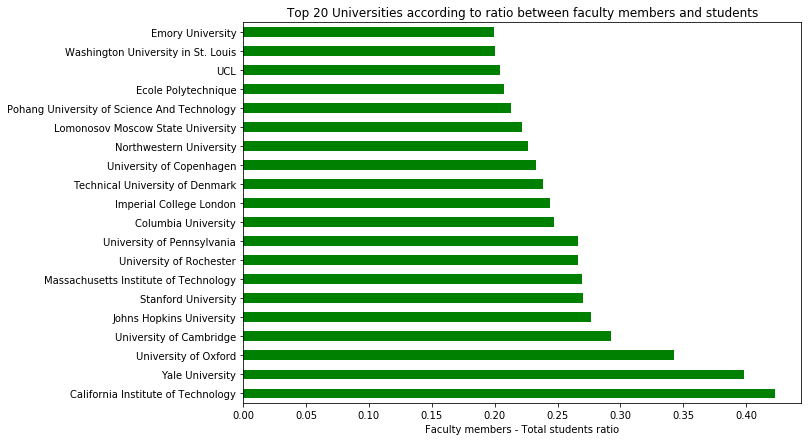

In [17]:
qs_faculty_students_rank_df[:20][COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,7), color='green')

plt.title('Top 20 Universities according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

It is interesting to note that the top three universities in this particular ranking have a ratio considerably higher than the other universities'. For the rest of the universities the value of the ratio decreases, but slower.

### Which are the best universities in terms of ratio of international students according to QS?

In [18]:
# Compute the ratio of international students
qs_ranking_df[COLUMN_INTERNATIONAL_RATIO] = qs_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] / qs_ranking_df[COLUMN_TOTAL_STUDENTS]

# Clean up the computation taking care of unknown values (previously set at -1)
qs_isratio_defined = (qs_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] != -1) | (qs_ranking_df[COLUMN_TOTAL_STUDENTS] != -1)
qs_ranking_df.loc[~qs_isratio_defined, COLUMN_INTERNATIONAL_RATIO] = float('nan')

# Define a dataset for the result computation
qs_international_students_rank_df = qs_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_INTERNATIONAL_STUDENTS,
                                                   COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_RATIO]]
qs_international_students_rank_df = qs_international_students_rank_df.sort_values(COLUMN_INTERNATIONAL_RATIO,
                                                                                  ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

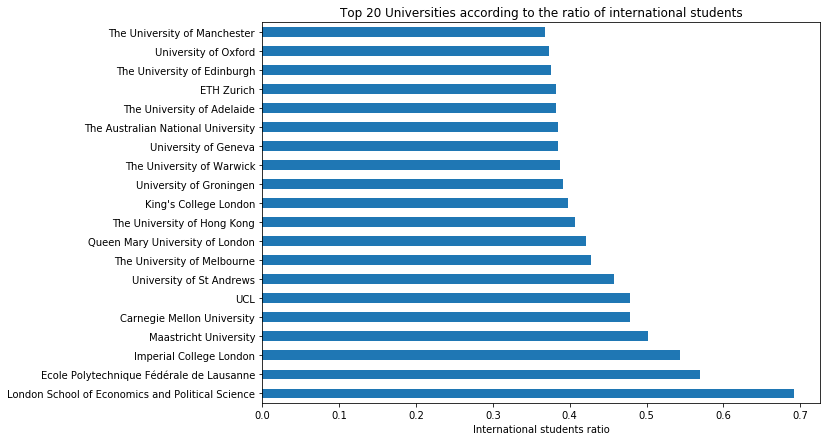

In [19]:
qs_international_students_rank_df[:20][COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10,7))

plt.title('Top 20 Universities according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

In this case we can see from the plot that *London School of Economics and Political Science* has a very high ratio of international students, followed by EPFL. In this case, the universities in the second half of the ranking have a very similar ratio of international students.

### Plot the results from QS ranking aggregating by region

For this question, we looked at the university with the best ratio in each region, for each of our defined ratios.

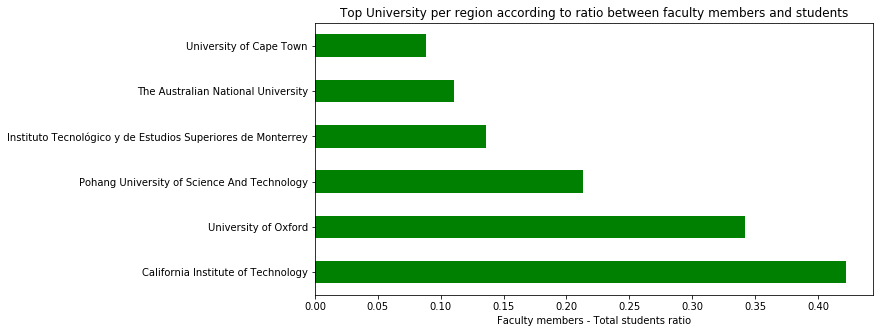

In [20]:
qs_faculty_student_ratio_by_region_df = qs_faculty_students_rank_df.groupby(COLUMN_REGION).head(1)
qs_faculty_student_ratio_by_region_df[COLUMN_FACULTY_RATIO].plot(kind='barh',figsize=(10,5),  color='green')

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

Then, for the international students' ratio:

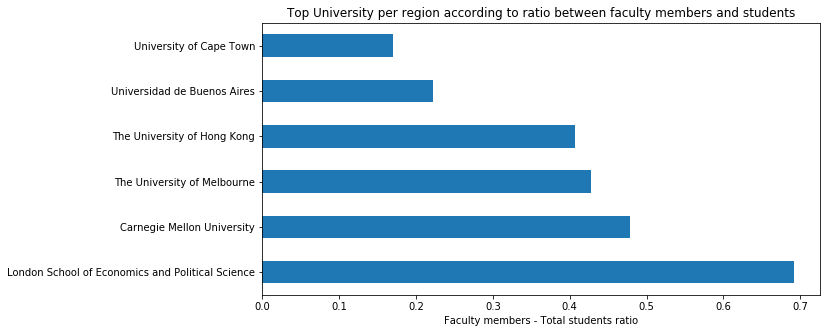

In [21]:
qs_international_students_ratio_by_region_df = qs_international_students_rank_df.groupby(COLUMN_REGION).head(1)
qs_international_students_ratio_by_region_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10,5))

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

### Plot the results from QS ranking aggregating by country

For this question, we plotted the universities with the highest values for each of the previously calculated ratios.

First for the faculty to student ratio:

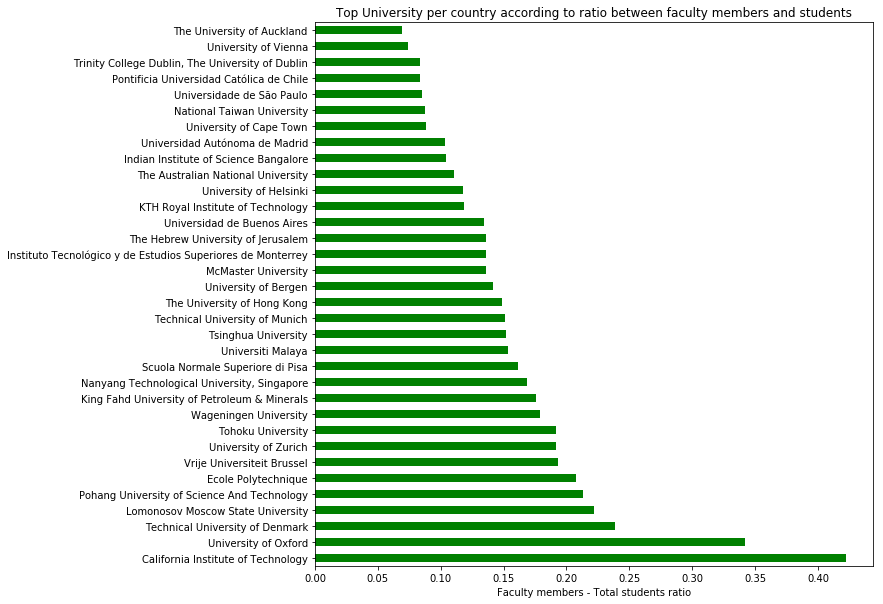

In [22]:
qs_faculty_student_ratio_by_country_df = qs_faculty_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
qs_faculty_student_ratio_by_country_df[COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,10), color='green')

plt.title('Top University per country according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

And then for the international students' ratio:

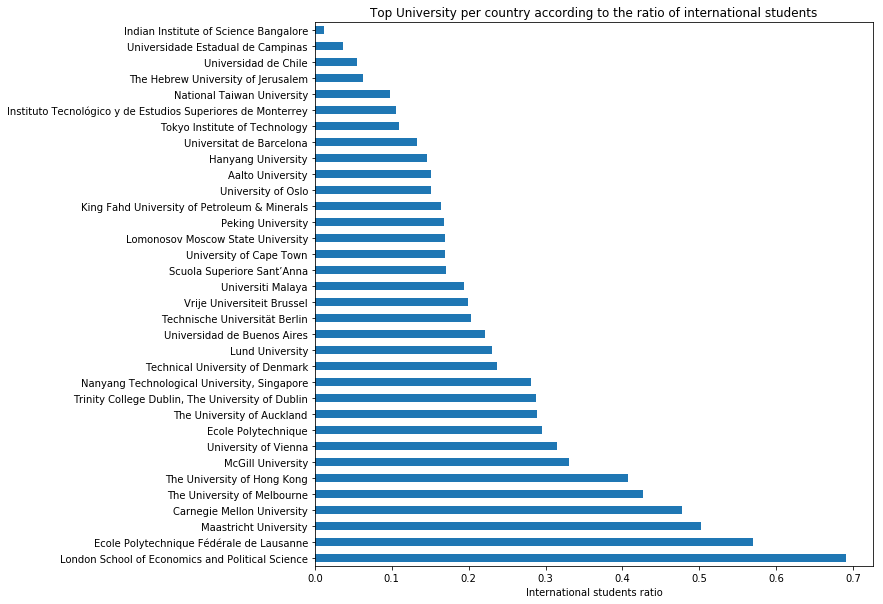

In [23]:
qs_international_students_ratio_by_country_df = qs_international_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
qs_international_students_ratio_by_country_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per country according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

# Task 2 - Scrape the Times ranking
We now obtain the 200 top-ranking universities in [www.timeshighereducation.com](http://www.timeshighereducation.com) (ranking 2018), and repeat the analysis of the previous point.

First, we define the auxiliary functions that we will need later on.

In [24]:
def compute_value_from_percentage(total, percentage):
    """Function that returns a value, calculated as a percentage of the given 'total'.
    
    total -- the value corresponding to 100%
    percentage -- the desired percentage of the total
    
    return the calculated value
    """
    
    total = int(total)
    percentage = float(percentage)
    
    return round((total/100) * percentage)

In [25]:
def compute_value_from_proportion(total, proportion):
    """Function to compute the proportion of a given total.
    
    total -- the value on which to calculate the percentage
    proportion -- the proportion value
    
    return the calculated value
    """
    
    total = int(total)
    proportion = float(proportion)
    
    return round(total / proportion)

In [26]:
def scrape_times_ranking():
    """Obtain the ranking from the top 200 of Times in a dataframe.
    
    return the dataframe containing all the informations of Times ranking
    """

    data = requests.get(TIMES_RANKING_JSON).json()
    university_list = []

    # Iterate through the first 200 universities in the ranking
    for i, d in enumerate(data['data'][:200]):
        
        # Preliminary computations to extract data
        intern_student = compute_value_from_percentage(clean_str_number(d['stats_number_students']), 
                                                       clean_str_number(d['stats_pc_intl_students'])
                                                      )
    
        faculty_member_total = compute_value_from_proportion(clean_str_number(d['stats_number_students']), 
                                                             clean_str_number(d['stats_student_staff_ratio'])
                                                            )
        
        # Determine region from the data of the QS ranking stored in the metadata
        try:
            region = COUNTRY_REGION_METADATA.get_value(d['location'], 'Region')
        except KeyError:
            region = 'NaN'
    
        # Store the parsed information into a dictionary
        info = {COLUMN_RANK: (i+1), 
                COLUMN_UNIVERSITY_NAME: search_standard_name(d['name']), 
                COLUMN_COUNTRY: d['location'],
                COLUMN_REGION: region,
                COLUMN_TOTAL_STUDENTS: int(clean_str_number(d['stats_number_students'])),
                COLUMN_INTERNATIONAL_STUDENTS: int(intern_student),
                COLUMN_TOTAL_FACULTY: int(faculty_member_total)
               }
    
        university_list.append(info)
   
    times_ranking_df = pd.DataFrame.from_dict(university_list)
    return times_ranking_df

After defining the functions we need, we scrape the webpage and serialize the dataframe. If the serialized object already exists, we deserialize it and do not scrape the page again. 

In [27]:
try:
    times_ranking_df = pd.read_pickle('serial/times_save.p')
except (OSError, IOError) as e:
    times_ranking_df = scrape_times_ranking()
    times_ranking_df.to_pickle('serial/times_save.p')
    
times_ranking_df.head()

,Country,Rank,Region,Total Faculty,Total International Students,Total Students,University Name
0,United Kingdom,1,Europe,1822,7755,20409,University of Oxford
1,United Kingdom,2,Europe,1687,6436,18389,University of Cambridge
2,United States,3,North America,340,596,2209,California Institute of Technology
3,United States,4,North America,2113,3486,15845,Stanford University
4,United States,5,North America,1285,3800,11177,Massachusetts Institute of Technology


We then set a meaningful unique index.

In [28]:
times_ranking_df.set_index(COLUMN_UNIVERSITY_NAME, inplace=True)

Even after extrapolating the region information from the first dataset, we might have some missing data. Those will be manually handled to completely fill in the table.

In [29]:
times_ranking_df[times_ranking_df[COLUMN_REGION] == 'NaN']

,Country,Rank,Region,Total Faculty,Total International Students,Total Students
University Name,,,,,,
University of Luxembourg,Luxembourg,179,NaN,340,2832,4969
Lomonosov Moscow State University,Russian Federation,194,NaN,4005,6432,29236


In [30]:
# Manually fix the missing data
times_ranking_df.set_value('University of Luxembourg', COLUMN_REGION, 'Europe')
times_ranking_df.set_value('Lomonosov Moscow State University', COLUMN_REGION, 'Europe')

# Verification
times_ranking_df[times_ranking_df[COLUMN_COUNTRY] == 'Luxembourg']

,Country,Rank,Region,Total Faculty,Total International Students,Total Students
University Name,,,,,,
University of Luxembourg,Luxembourg,179,Europe,340,2832,4969


### Which are the best universities in terms of ratio between faculty members and students according to Times?

In [31]:
# Compute the ratio between faculty member and students
times_ranking_df[COLUMN_FACULTY_RATIO] = (times_ranking_df[COLUMN_TOTAL_FACULTY] /
                                          times_ranking_df[COLUMN_TOTAL_STUDENTS])

# Clean up the computation, taking care of unknown values (previously set at -1)
times_isratio_defined = ((times_ranking_df[COLUMN_TOTAL_FACULTY] != -1) |
                         (times_ranking_df[COLUMN_TOTAL_STUDENTS] != -1))
times_ranking_df.loc[~times_isratio_defined, COLUMN_FACULTY_RATIO] = float('nan')

# Define a dataset for the result computation
times_faculty_students_rank_df = times_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_TOTAL_FACULTY,
                                                   COLUMN_TOTAL_STUDENTS, COLUMN_FACULTY_RATIO]]
times_faculty_students_rank_df = times_faculty_students_rank_df.sort_values(COLUMN_FACULTY_RATIO,
                                                                            ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

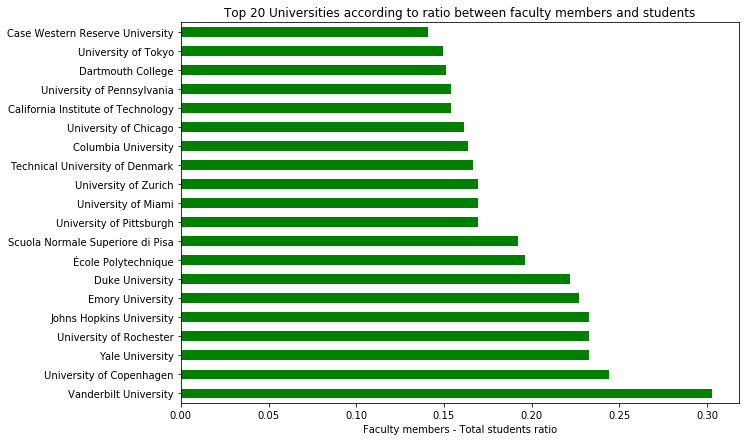

In [32]:
times_faculty_students_rank_df[:20][COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,7), color='green')

plt.title('Top 20 Universities according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

In this ranking, there are two groups of universities with very similar values for their *faculty to students* ratio. This is different from the previous plot for the QS ranking, where the decrease in the ratio value was more gradual.

### Which are the best universities in terms of ratio of international students according to Times?

In [33]:
# Compute the ratio of international students
times_ranking_df[COLUMN_INTERNATIONAL_RATIO] = (times_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] /
                                                times_ranking_df[COLUMN_TOTAL_STUDENTS])

# Clean up the computation taking care of unknown values (previously set at -1)
times_isratio_defined = ((times_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] != -1) |
                         (times_ranking_df[COLUMN_TOTAL_STUDENTS] != -1))
times_ranking_df.loc[~times_isratio_defined, COLUMN_INTERNATIONAL_RATIO] = float('nan')

# Define a dataset for the result computation
times_international_students_rank_df = times_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_INTERNATIONAL_STUDENTS,
                                                         COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_RATIO]]
times_international_students_rank_df = times_international_students_rank_df.sort_values(COLUMN_INTERNATIONAL_RATIO,
                                                                                        ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

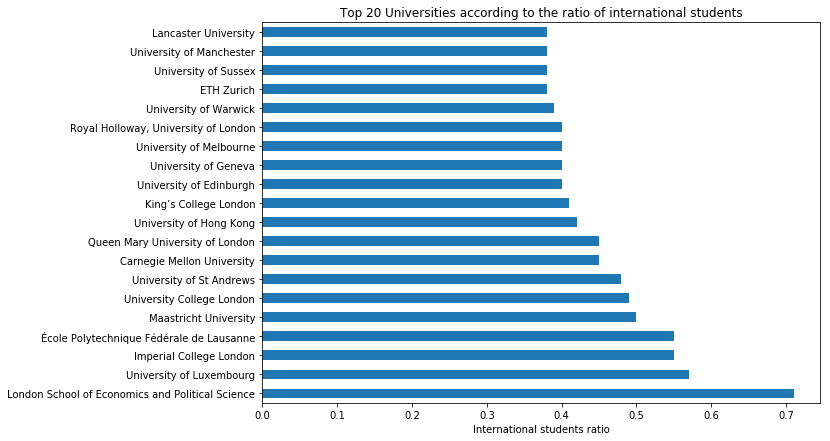

In [34]:
times_international_students_rank_df[:20][COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10,7))

plt.title('Top 20 Universities according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

This plot is very similar to the one for the QS ranking, regarding the fact that the universities in the second half of the ranking have a very similar ratio of international students.

### Plot the results from Times ranking aggregating by region

For this question, we looked at the university with the best ratio in each region, for each of our defined ratios.

For the faculty to student ratio:

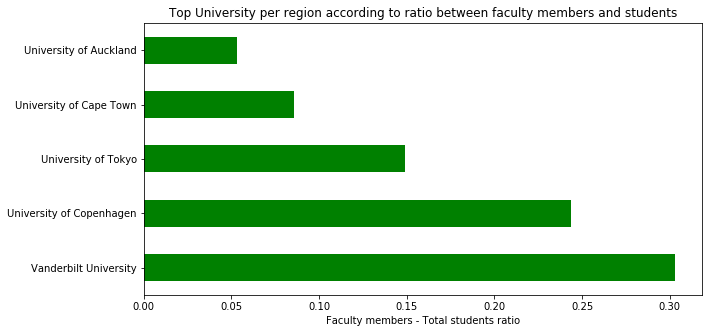

In [35]:
times_faculty_student_ratio_by_region_df = times_faculty_students_rank_df.groupby(COLUMN_REGION).head(1)
times_faculty_student_ratio_by_region_df[COLUMN_FACULTY_RATIO].plot(kind='barh',figsize=(10,5),  color='green')

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

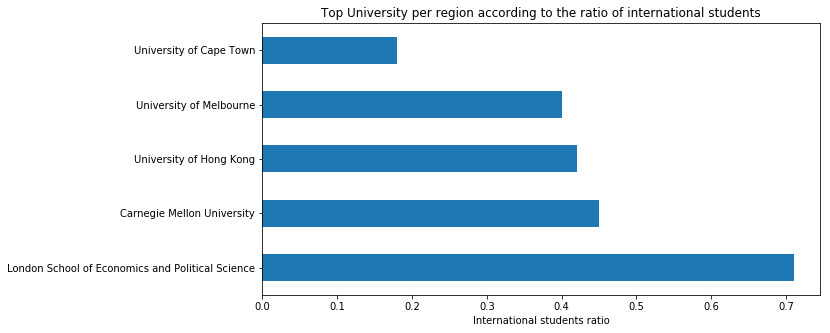

In [36]:
times_international_students_ratio_by_region_df = times_international_students_rank_df.groupby(COLUMN_REGION).head(1)
times_international_students_ratio_by_region_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10, 5))

plt.title('Top University per region according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

### Plot the results from Times ranking aggregating by country

For this question, we looked at the university with the best ratio in each country, for each of our defined ratios.

For the faculty members to total students ratio:

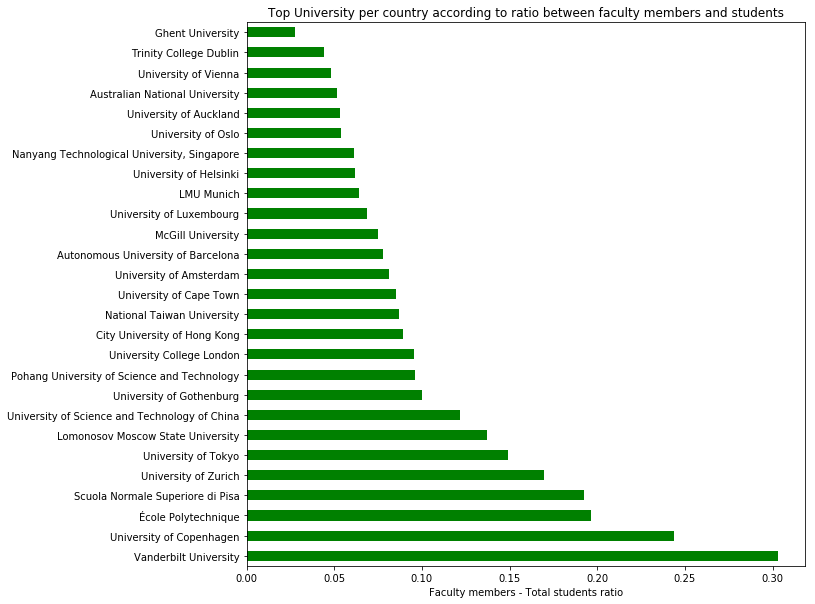

In [37]:
times_faculty_student_ratio_by_country_df = times_faculty_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
times_faculty_student_ratio_by_country_df[COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,10), color='green')

plt.title('Top University per country according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

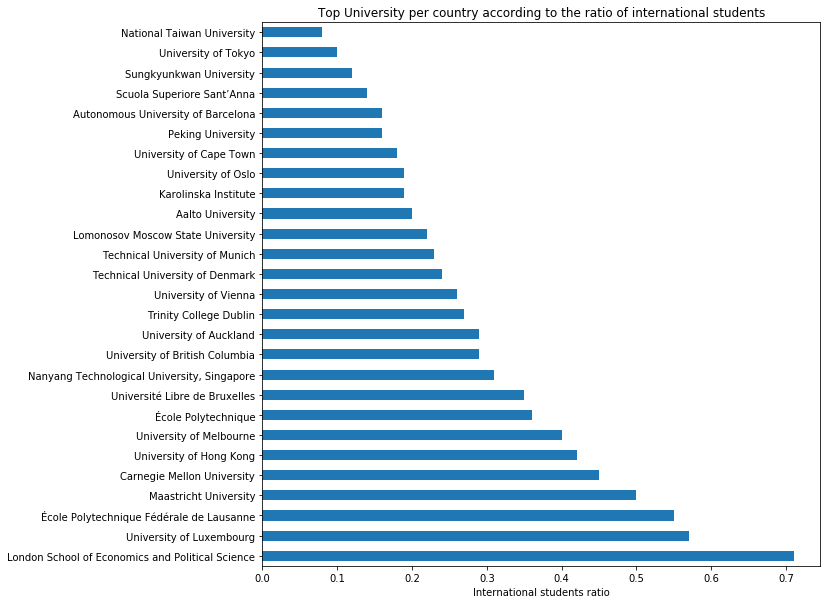

In [38]:
times_international_students_ratio_by_country_df = times_international_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
times_international_students_ratio_by_country_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per country according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

# Task 3 - Merge the dataframes
In this task we merge the two DataFrames created in tasks 1 and 2 using university names.

Merging is trivial because we have already handled the standardization of University Names during the scraping task. As explained previously, we looked up the name in the WikiData database to obtain the WikiData formatted entry (it is carried out using the function `search_standard_name`).

Therefore and since both rankings have names from the WikiData database, merging gives a perfect result. We first do some reorganization of the two dataframes as follows.

In [39]:
# Create column containing university name on which do the merging
qs_ranking_df[COLUMN_UNIVERSITY_NAME] = qs_ranking_df.index
times_ranking_df[COLUMN_UNIVERSITY_NAME] = times_ranking_df.index

In [40]:
# Clean up the values in QS ranking for perfect merge
qs_ranking_df[COLUMN_UNIVERSITY_NAME] = qs_ranking_df[COLUMN_UNIVERSITY_NAME].str.strip()
qs_ranking_df[COLUMN_COUNTRY] = qs_ranking_df[COLUMN_COUNTRY].str.strip()

# Clean up the values in Times ranking for perfect merge
times_ranking_df[COLUMN_UNIVERSITY_NAME] = times_ranking_df[COLUMN_UNIVERSITY_NAME].str.strip()
times_ranking_df[COLUMN_COUNTRY] = times_ranking_df[COLUMN_COUNTRY].str.strip()

Then we merge the two dataframes into one:

In [41]:
# Merge the dataframes via an outer join on the cols name, country and region
merged_ranking_df = pd.merge(qs_ranking_df, times_ranking_df, 
                             on=[COLUMN_UNIVERSITY_NAME, COLUMN_REGION, COLUMN_COUNTRY], 
                             how='outer', 
                             suffixes=('_QS', '_TM')
                            )

# Use the University Name as an index for the merged dataframe too
merged_ranking_df.set_index(COLUMN_UNIVERSITY_NAME, inplace=True)

merged_ranking_df.head()

,Country,Rank_QS,Region,Total Faculty_QS,Total International Faculty,Total International Students_QS,Total Students_QS,Total Faculty / Total Student_QS,Total International Students / Total Students_QS,Rank_TM,Total Faculty_TM,Total International Students_TM,Total Students_TM,Total Faculty / Total Student_TM,Total International Students / Total Students_TM
University Name,,,,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1.0,North America,2982.0,1679.0,3717.0,11067.0,0.269450,0.335863,5.0,1285.0,3800.0,11177.0,0.114968,0.339984
Stanford University,United States,2.0,North America,4285.0,2042.0,3611.0,15878.0,0.269870,0.227422,4.0,2113.0,3486.0,15845.0,0.133354,0.220006
Harvard University,United States,3.0,North America,4350.0,1311.0,5266.0,22429.0,0.193945,0.234785,6.0,2284.0,5285.0,20326.0,0.112368,0.260012
California Institute of Technology,United States,4.0,North America,953.0,350.0,647.0,2255.0,0.422616,0.286918,3.0,340.0,596.0,2209.0,0.153916,0.269805
University of Cambridge,United Kingdom,5.0,Europe,5490.0,2278.0,6699.0,18770.0,0.292488,0.356899,2.0,1687.0,6436.0,18389.0,0.091740,0.349992


The universities that appear in both rankings have some information repeated twice. These repeated values are different in many cases, although very similar. For the universities that only appear in one of the rankings, many of the values are missing.

We compute the mean for the repeated columns that contain information about the university - while still keeping track of the university position in each ranking. This also allows us to remove as many NaN values as possible, since the mean computation is ignoring the missing values.

In [42]:
# Replace -1 values for None values
merged_ranking_df.replace(-1, float('nan'), inplace=True)

cols = [COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_STUDENTS, COLUMN_TOTAL_FACULTY, 
        COLUMN_FACULTY_RATIO, COLUMN_INTERNATIONAL_RATIO]

for x in cols:
    merged_ranking_df[x] = merged_ranking_df[[x + '_QS', x + '_TM']].mean(axis=1)
    merged_ranking_df.drop([x + '_QS', x + '_TM'], axis=1, inplace=True)

Sample of the final result:

In [43]:
merged_ranking_df.head()

,Country,Rank_QS,Region,Total International Faculty,Rank_TM,Total Students,Total International Students,Total Faculty,Total Faculty / Total Student,Total International Students / Total Students
University Name,,,,,,,,,,
Massachusetts Institute of Technology,United States,1.0,North America,1679.0,5.0,11122.0,3758.5,2133.5,0.192209,0.337924
Stanford University,United States,2.0,North America,2042.0,4.0,15861.5,3548.5,3199.0,0.201612,0.223714
Harvard University,United States,3.0,North America,1311.0,6.0,21377.5,5275.5,3317.0,0.153157,0.247399
California Institute of Technology,United States,4.0,North America,350.0,3.0,2232.0,621.5,646.5,0.288266,0.278362
University of Cambridge,United Kingdom,5.0,Europe,2278.0,2.0,18579.5,6567.5,3588.5,0.192114,0.353446


## Task 4 - Exploratory analysis

#### General insights

We can first look at the descriptive statistics for all the numeric variables in the merged dataframe.

In [44]:
merged_ranking_df.describe()

,Rank_QS,Total International Faculty,Rank_TM,Total Students,Total International Students,Total Faculty,Total Faculty / Total Student,Total International Students / Total Students
count,200.000000,198.000000,200.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,100.500000,786.409091,100.500000,25165.810954,5024.203180,2263.019435,0.098750,0.213516
std,57.879185,666.690652,57.879185,15972.072901,3669.446102,1758.101859,0.052526,0.116897
min,1.000000,1.000000,1.000000,523.500000,42.000000,89.000000,0.012830,0.009892
25%,50.750000,327.000000,50.750000,14538.500000,2573.750000,1068.000000,0.066923,0.128645
50%,100.500000,599.500000,100.500000,23101.500000,4344.000000,2000.000000,0.087725,0.190030
75%,150.250000,1027.750000,150.250000,32136.000000,6831.500000,2988.000000,0.120321,0.284823
max,200.000000,3905.000000,200.000000,141939.000000,27109.000000,16421.000000,0.315451,0.700689


It is interesting to see how the top universities are distributed among the continents. Nearly half of these top universities are in Europe, and around one fourth of them are in North America.

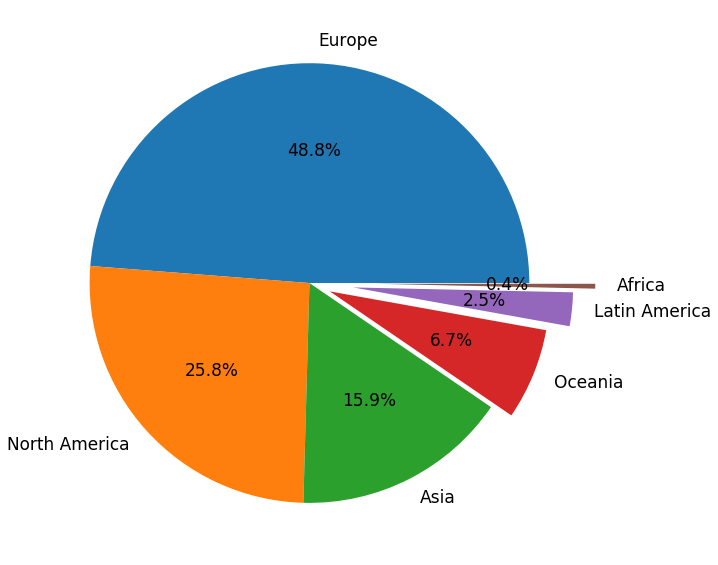

In [45]:
explode = (0, 0, 0, 0.1, 0.2, 0.3)
merged_ranking_df[COLUMN_REGION].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10,10),fontsize=17, explode = explode)

plt.ylabel("")
plt.axis('equal')
plt.show()

We can classify the universities according to their size. We are considering that their size is determined by the number of students, with the same classification that was used for the QS ranking (Described [here](http://www.iu.qs.com/university-rankings/qs-classifications/)).

In [46]:
def university_sizes(x):
    """Returns a size label based on the number of students."""
    if not x:
        return None
    else:
        return ('Small' if x < 5000 else 'Medium' if x < 12000
                else 'Large' if x < 30000 else 'Extra Large')

In [47]:
merged_ranking_df['Size'] = merged_ranking_df[COLUMN_TOTAL_STUDENTS].apply(lambda x: university_sizes(x))

When we look at the proportions of top universities according to their size, it is interesting to see that over 80% of them have more than 30,000 students - and out of these, 30% are considered to be extra large.

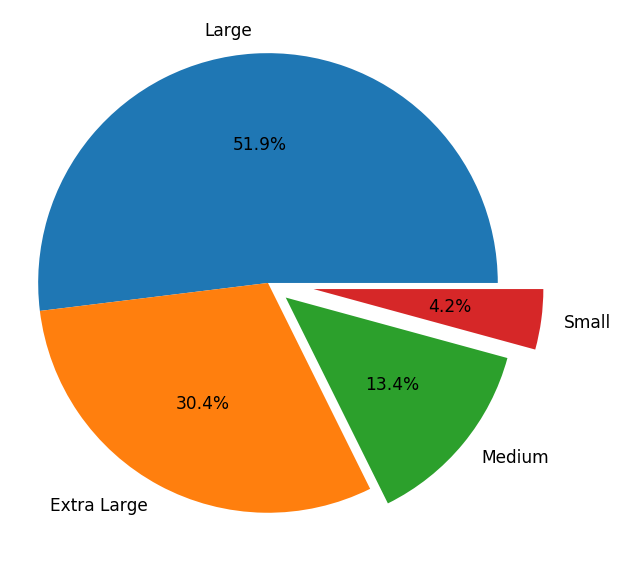

In [48]:
explode = (0, 0, 0.1, 0.2)
merged_ranking_df['Size'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10,10), fontsize=17, explode = explode)

plt.ylabel("")
plt.axis('equal')
plt.show()

#### Checking for a consistency on the computed ratios for universities in a certain region or of a certain size

With the following boxplots we want to identify outliers in the faculty per student ratio, and see if there is a difference in the ratio depending on the region and size of the university. 

We can observe that for the faculty to student ratio there are indeed differences depending on the regions. If we focus our interesting in the North American and the European universities (as shown previously, they account for nearly 75% of the dataset), we see that the medians are similar and below 0.10. However, for European universities the distribution of the ratio is more symmetrical.

Regarding the size there are differences between the small and the extra large universities, whereas the distribution is similar for medium and large ones.

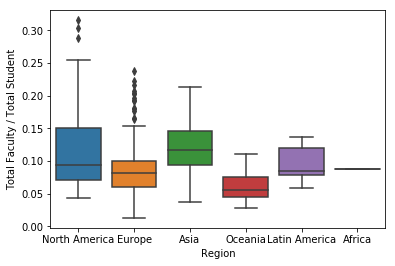

In [49]:
sns.boxplot(x=COLUMN_REGION, y=COLUMN_FACULTY_RATIO, data=merged_ranking_df)

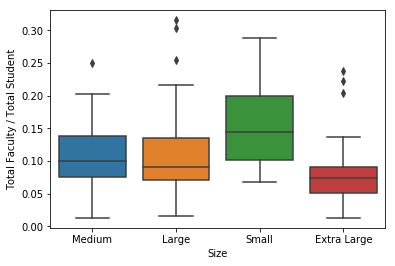

In [50]:
sns.boxplot(x='Size', y=COLUMN_FACULTY_RATIO, data=merged_ranking_df);

We now want to repeat the previous analysis for the international students ratio.

In the case of the international students ratio, the universities in Latin America are some of the least international ones. The universities in Oceania appear to be the most international ones. In this case, the distribution of the ratio for North American Universities is more symmetrical than for European, although it has a similar median for both countries.

Regarding the size, the median for the ratio is very similar for the four sizes of university. We can also observe that this ratio is more variable for small universities.

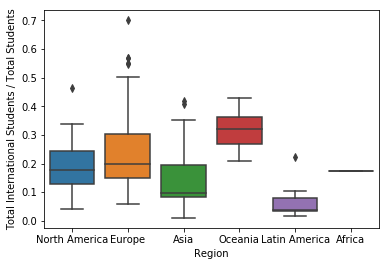

In [51]:
sns.boxplot(x=COLUMN_REGION, y=COLUMN_INTERNATIONAL_RATIO, data=merged_ranking_df);

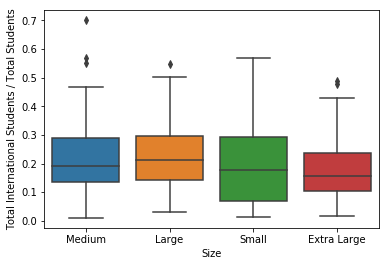

In [52]:
sns.boxplot(x='Size', y=COLUMN_INTERNATIONAL_RATIO, data=merged_ranking_df);

#### Checking for a consistency for students and faculty members when a university has a large international students ratio

For this task we classify universities in three groups depending on their internationality ratio. We then plot the number of students and the ratio of faculty members for each of these groups.

In [53]:
int_val = merged_ranking_df[COLUMN_INTERNATIONAL_RATIO].max() / 3
int_class = ['Low', 'Medium', 'High']
merged_ranking_df['Internationality'] = merged_ranking_df[COLUMN_INTERNATIONAL_RATIO].apply(
    lambda x: int_class[0] if x < int_val else int_class[1] if x < int_val*2 else int_class[2])

From the boxplots we can observe that the most international universities seem to have a lower number of total students, i.e. they appear to be smaller in size.

The faculty to students ratio has similar medians for the three groups of universities. We can also see that the number of outliers is the lowest for the *most international* universities.

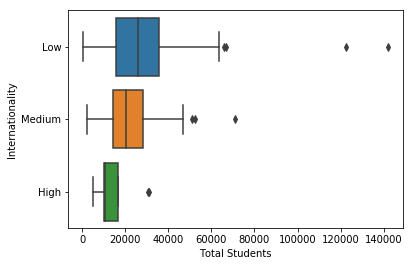

In [54]:
sns.boxplot(x=COLUMN_TOTAL_STUDENTS, y='Internationality', data=merged_ranking_df, order=int_class);

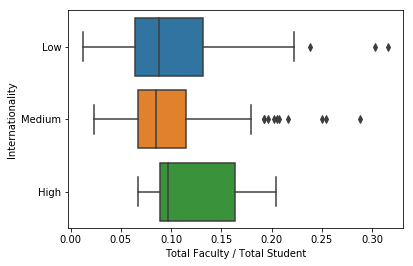

In [55]:
sns.boxplot(x=COLUMN_FACULTY_RATIO, y='Internationality', data=merged_ranking_df, order=int_class);

TODO comment the above plots (I think it's all done except point 3)
    1. Why these plots?
    2. Which correlations we found?
    3. What are we missing?

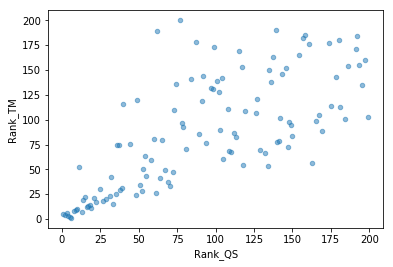

In [56]:
merged_ranking_df.plot(x=COLUMN_RANK + '_QS', y=COLUMN_RANK+'_TM', kind='scatter', alpha=.5)

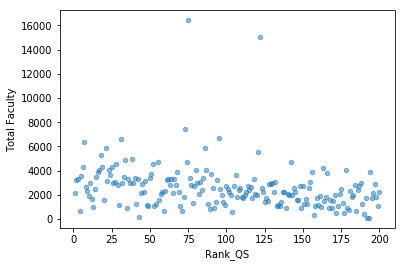

In [57]:
merged_ranking_df.plot(x=COLUMN_RANK + '_QS', y=COLUMN_TOTAL_FACULTY, kind='scatter', alpha=.5)

#### Correlation matrix

Lastly, we obtain the correlation matrix for all the numeric variables. We then plot it for a better interpretation.

In [58]:
cols = ['{0}_QS'.format(COLUMN_RANK), '{0}_TM'.format(COLUMN_RANK), COLUMN_REGION,
        COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_STUDENTS, COLUMN_TOTAL_FACULTY,
        COLUMN_FACULTY_RATIO, COLUMN_INTERNATIONAL_RATIO]

merged_ranking_df[cols].corr()

,Rank_QS,Rank_TM,Total Students,Total International Students,Total Faculty,Total Faculty / Total Student,Total International Students / Total Students
Rank_QS,1.000000,0.731208,-0.042923,-0.322067,-0.266517,-0.357019,-0.366680
Rank_TM,0.731208,1.000000,-0.154720,-0.325885,-0.353415,-0.278616,-0.225795
Total Students,-0.042923,-0.154720,1.000000,0.559428,0.734180,-0.266081,-0.188185
Total International Students,-0.322067,-0.325885,0.559428,1.000000,0.404632,-0.196919,0.539103
Total Faculty,-0.266517,-0.353415,0.734180,0.404632,1.000000,0.357702,-0.120258
Total Faculty / Total Student,-0.357019,-0.278616,-0.266081,-0.196919,0.357702,1.000000,0.031720
Total International Students / Total Students,-0.366680,-0.225795,-0.188185,0.539103,-0.120258,0.031720,1.000000


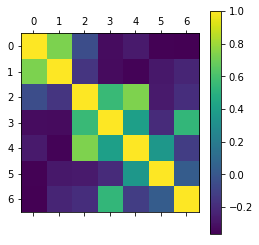

In [59]:
plt.matshow(merged_ranking_df[cols].corr())
plt.colorbar()

TODO: Choose one from below

From the above plot we can see that there aren't any strong correlations, except for the two ranks, between the variables we are considering. Since there is no redundant information, we will use *all* of these variables for the ranking system we develop in task 5. 

From the above plot we can see that the strongest correlations are found between the two ranks and between the number of total students and the number of faculty members. 

We consider that there is no redundant information, and we will use *all* of these variables for computing our ranking system in task 5.

## Task 5 - Finding the best university

Even though at the end of task 4 we noticed there is a somewhat strong correlation between the two ranks, we don't have enough data to recreate their scoring criteria. Nevertheless, we have enough variables to create a new ranking system - and we can use the already calculated ranks as a small bias. 

In our view, a ranking based on arithmetic means between everything we know about the two ranks wouldn't give us a satisfactory result. This would give us a system with relatively high correlations with our previous one but that is not exactly what we want to achieve. Our rationale was that, even if a certain criteria allows for a really good differentiation between all the universities in the world, as a whole, it might not be the best criteria when addressing only a subset of these - namely the *elite*.

### 5.1 - Preparing the data

#### Removing universities with NaN values 
If we can't properly score a university because of missing data, we remove it from the ranking altogether. Allowing those universities to be score based on the parameters they have left, seen that we already have little variables to rely on, would increase their ranks' volatility by a big margin.

In [60]:
qs_ranking_df.dropna(inplace=True)
times_ranking_df.dropna(inplace=True)

#### Reseting the index

In [61]:
qs_ranking_df.set_index(qs_ranking_df['Rank'], drop=True, inplace=True)
times_ranking_df.set_index(times_ranking_df['Rank'], drop=True, inplace=True)

#### Removing unnecessary columns
We decided to ignore country-specific biases. This means that, from this point on, 'Country' and 'Region' should have no impact in our final university ranking.

In [62]:
qs_ranking_df.drop(['Country', 'Region'], axis=1, inplace=True)
times_ranking_df.drop(['Country', 'Region'], axis=1, inplace=True)

#### Renaming columns

In [63]:
# QS Ranking dataframe
qs_rename_dic = {
    'International faculty member': 'Total International Faculty',
    'International student': 'Total International Students',
    'Rank': 'Rank',
    'Total faculty member': 'Total Faculty',
    'Total student': 'Total Students',
    'Faculty/students ratio': 'Total Faculty / Total Student',
    'Intern/student ratio': 'Total International Students / Total Students',
    'University name': 'University Name'
}
qs_ranking_df.rename(columns=qs_rename_dic, inplace=True)

In [64]:
# TM Ranking dataframe
times_rename_dic = {
    'International student': 'Total International Students',
    'Rank': 'Rank',
    'Total faculty member': 'Total Faculty',
    'Total student': 'Total Students',
    'Faculty/students ratio': 'Total Faculty / Total Student',
    'Intern/student ratio': 'Total International Students / Total Students',
    'University name': 'University Name'
}
times_ranking_df.rename(columns=times_rename_dic, inplace=True)

---
Samples:

In [65]:
qs_ranking_df.head()

,Rank,Total Faculty,Total International Faculty,Total International Students,Total Students,Total Faculty / Total Student,Total International Students / Total Students,University Name
Rank,,,,,,,,
1,1,2982,1679,3717,11067,0.269450,0.335863,Massachusetts Institute of Technology
2,2,4285,2042,3611,15878,0.269870,0.227422,Stanford University
3,3,4350,1311,5266,22429,0.193945,0.234785,Harvard University
4,4,953,350,647,2255,0.422616,0.286918,California Institute of Technology
5,5,5490,2278,6699,18770,0.292488,0.356899,University of Cambridge


In [66]:
times_ranking_df.head()

,Rank,Total Faculty,Total International Students,Total Students,Total Faculty / Total Student,Total International Students / Total Students,University Name
Rank,,,,,,,
1,1,1822,7755,20409,0.089274,0.379979,University of Oxford
2,2,1687,6436,18389,0.091740,0.349992,University of Cambridge
3,3,340,596,2209,0.153916,0.269805,California Institute of Technology
4,4,2113,3486,15845,0.133354,0.220006,Stanford University
5,5,1285,3800,11177,0.114968,0.339984,Massachusetts Institute of Technology


---

### 5.2 - Calculating the relationship between each variable and 'Rank'

To fully understand how we should go about creating a new ranking system, we first try to learn which *numerical* variables most strongly correlate to rank. Now, since the information we have is very little do do a proper evaluation on things like 'research' we will purposefully assume a certain bias: "Whatever it is the top universities are doing that we don't know, they must be doing it right - since they are at the top of their ranking".

The above assumption translates into creating a weighted distribution for rank correlation (instead of simply analysing the sampled values). Each university will have an assigned weight that decreses linearly, in a way directly proportional to rank.

In [67]:
RANK_MAX = 1
RANK_MIN = 200

def get_sample_weight(rank, rank_min, rank_max):
    '''
    Calculates the weight of a sample according to
    its respective rank (and the rank's range).
    '''
    return (rank_min - (rank - rank_max))

def get_weighted_mean(column):
    '''
    Calculates the weighted mean over a column's values.
    The weights are calculated linearly, always decresing
    proportionaly to the rank_offset (rank-1).
    '''
    weighted_sum = 0
    hypothetical_samples = -1
    
    for rank_offset, sample in column.iteritems():
        sample_weight = get_sample_weight(rank_offset+1, RANK_MIN, RANK_MAX)
        weighted_sum += sample_weight * sample
        hypothetical_samples += sample_weight
    return weighted_sum / hypothetical_samples

def get_weighted_std(column):
    '''
    Calculates the weighted santdard deviation over a 
    column's values.
    '''
    weighted_mean = get_weighted_mean(column)
    weighted_sum = 0
    hypothetical_samples = -1
    
    for rank_offset, sample in column.iteritems():
        sample_weight = get_sample_weight(rank_offset+1, RANK_MIN, RANK_MAX)
        weighted_sum += sample_weight * pow(sample_weight - weighted_mean, 2.0)
        hypothetical_samples += sample_weight
    return weighted_sum / hypothetical_samples

def get_weighted_var(column):
    '''
    Calculates the weighted variance over a column's values.
    '''
    weighted_std = get_weighted_std(column)
    return pow(weighted_std, 2.0)

To be able to compare the different distributions afterwards, we use a normalized version of the ranking dataframes to calculate the correlation dataframe. That dataframe simply divides all the values in each column by that column's maximum value, to make sure we have values between 0 and 1 - represented by **numeric_component_normalized_df**.

In [68]:
def get_rank_correlation_df(dataframe):
    '''
    Creates a new dataframe with information about
    each of the variables' distributions, according
    to rank.
    '''
    ranking_correlation_df = pd.DataFrame()
    numeric_component_normalized_df = dataframe.drop(['University Name', 'Rank'], axis=1).apply(lambda x: x / x.max())
    ranking_correlation_df['Mean'] = numeric_component_normalized_df.apply(lambda x: x.mean())
    ranking_correlation_df['Weighted Mean'] = numeric_component_normalized_df.apply(lambda x: get_weighted_mean(x))
    ranking_correlation_df['Stddev'] = numeric_component_normalized_df.apply(lambda x: x.std())
    ranking_correlation_df['Weighted Stddev'] = numeric_component_normalized_df.apply(lambda x: get_weighted_std(x))
    ranking_correlation_df['Variance'] = numeric_component_normalized_df.apply(lambda x: x.var())
    ranking_correlation_df['Weighted Variance'] = numeric_component_normalized_df.apply(lambda x: get_weighted_var(x))
    return ranking_correlation_df

In [69]:
# Ranking-specific correlation dataframes
qs_rank_correlation_df = get_rank_correlation_df(qs_ranking_df)
times_rank_correlation_df = get_rank_correlation_df(times_ranking_df)

---
Samples:

In [70]:
qs_rank_correlation_df

,Mean,Weighted Mean,Stddev,Weighted Stddev,Variance,Weighted Variance
Total Faculty,0.177392,0.199911,0.122449,19832.896860,0.014994,3.933438e+08
Total International Faculty,0.200372,0.253856,0.170895,19818.583275,0.029205,3.927762e+08
Total International Students,0.187328,0.213368,0.144773,19829.325688,0.020959,3.932022e+08
Total Students,0.181128,0.183924,0.120725,19837.139991,0.014574,3.935121e+08
Total Faculty / Total Student,0.298034,0.333052,0.143052,19797.580485,0.020464,3.919442e+08
Total International Students / Total Students,0.304824,0.341022,0.168678,19795.467379,0.028452,3.918605e+08


In [71]:
times_rank_correlation_df

,Mean,Weighted Mean,Stddev,Weighted Stddev,Variance,Weighted Variance
Total Faculty,0.235009,0.257772,0.159000,19832.495678,0.025281,3.933279e+08
Total International Students,0.294740,0.329856,0.184522,19813.362878,0.034049,3.925693e+08
Total Students,0.356436,0.373280,0.192332,19801.841914,0.036992,3.921129e+08
Total Faculty / Total Student,0.259120,0.272871,0.156282,19828.487180,0.024424,3.931689e+08
Total International Students / Total Students,0.307967,0.328281,0.162893,19813.780594,0.026534,3.925859e+08


---

### 5.3 - Calculating each variable's score contribution

Now we can use the distributions we found to infer the ideal contribution of each parameter to the final evaluation. The criteria is simple:

    1. Pick a 'penalization' column
    2. Do a sum over that column's values
    3. Iterate over each criterion (row)
    4. Get their value for the 'penalization' column
    5. Assign a contribution (%) to that criterion
    6. Store the calculated contribution in a new column
    
Firstly, the contribution assigned to each criterion, in step 5, is *equal* to the percentage of the sum (step 2) represented by the criterion's value (step 4).

Secondly, as our 'penalization' column we can use either *Stddev* or *Variance* (or their weighted counterparts) and then power all their values to *-1*. This means that the higher the *Stddev* (or *Variance*) the smaller the final contribution of that parameter. This inherently makes it such that variables with a lower correlation to rank (hence higher values for *Stddev* and *Variance*) should have less impact on the final score.

In [72]:
def get_score_contribution_as_percentage(column):
    '''
    Calculates a percentage-wise score contribution, 
    linearly, according to a column's values.
    '''
    criteria_sum = column.sum()
    contribution_dict = {}
    
    for criterion, criterion_value in column.iteritems():
        contribution_dict[criterion] = 100 * (criterion_value / criteria_sum)
    return contribution_dict

In [73]:
# Calculate contribution maps for QS and TM rankings
qs_contribution_percentage_map = get_score_contribution_as_percentage(qs_rank_correlation_df['Variance'].apply(lambda x: 1/x))
times_contribution_percentage_map = get_score_contribution_as_percentage(times_rank_correlation_df['Variance'].apply(lambda x: 1/x))

# Assign the contribution percentages to the correlation dataframes
qs_rank_correlation_df['Contribution Percent'] = pd.Series(qs_contribution_percentage_map)
times_rank_correlation_df['Contribution Percent'] = pd.Series(times_contribution_percentage_map)

---
Samples:

In [74]:
qs_rank_correlation_df

,Mean,Weighted Mean,Stddev,Weighted Stddev,Variance,Weighted Variance,Contribution Percent
Total Faculty,0.177392,0.199911,0.122449,19832.896860,0.014994,3.933438e+08,22.137434
Total International Faculty,0.200372,0.253856,0.170895,19818.583275,0.029205,3.927762e+08,11.365377
Total International Students,0.187328,0.213368,0.144773,19829.325688,0.020959,3.932022e+08,15.836693
Total Students,0.181128,0.183924,0.120725,19837.139991,0.014574,3.935121e+08,22.774432
Total Faculty / Total Student,0.298034,0.333052,0.143052,19797.580485,0.020464,3.919442e+08,16.219984
Total International Students / Total Students,0.304824,0.341022,0.168678,19795.467379,0.028452,3.918605e+08,11.666080


In [75]:
times_rank_correlation_df

,Mean,Weighted Mean,Stddev,Weighted Stddev,Variance,Weighted Variance,Contribution Percent
Total Faculty,0.235009,0.257772,0.159000,19832.495678,0.025281,3.933279e+08,22.656267
Total International Students,0.294740,0.329856,0.184522,19813.362878,0.034049,3.925693e+08,16.822252
Total Students,0.356436,0.373280,0.192332,19801.841914,0.036992,3.921129e+08,15.483901
Total Faculty / Total Student,0.259120,0.272871,0.156282,19828.487180,0.024424,3.931689e+08,23.451253
Total International Students / Total Students,0.307967,0.328281,0.162893,19813.780594,0.026534,3.925859e+08,21.586328


---

### 5.4 - Calculate criterion-specific score for each university

After we estimate the criterion-specific contributions, we then need to find a way to calculate a university's score for that same criterion. Again, we need to pick a 'penalization' function. 

The way we do it is assuming a *Gaussian* distribution around the *weighted mean* (and with a certain standard deviation). By finding **gaussian(x, mean, std)**, being *x* the university's value for a certain criterion, we get an overall score between 0 and 1 - being the highest score closer to the *weighted mean*.

As a last step, we multiply this criterion-specific *score* by the criterion-specific *contribution* to get the final score's percentage - for a given university, for a given criterion.

In [76]:
def gaussian(x, mean, std):
    '''
    Returns the value for a gaussian function
    with mean 'mean' and standard deviation 'std',
    at coordinate 'x'.
    '''
    return np.exp(-pow(x - mean, 2.0) / (2 * pow(std, 2.0)))

In [77]:
def get_criterion_specific_score(column, correlation_df):
    '''
    Returns a dictionary with a university's name as 
    keys and the column criterion's score as values.
    '''
    criterion_contribution = correlation_df['Contribution Percent'].get(column.name)
    criterion_mean = correlation_df['Weighted Mean'].get(column.name)
    criterion_std = correlation_df['Stddev'].get(column.name)

    normalized_column = column / column.max()
    university_score_dict = {}
    
    for university_name, criterion_x in normalized_column.iteritems():
        criterion_value = gaussian(criterion_x, criterion_mean, criterion_std)
        university_score_dict[university_name] = criterion_value * criterion_contribution
        
    return university_score_dict

# Setting index to 'University Name' for both dataframes
qs_ranking_df.set_index(qs_ranking_df['University Name'], drop=True, inplace=True)
times_ranking_df.set_index(times_ranking_df['University Name'], drop=True, inplace=True)

# Removing unnecessary columns
qs_ranking_df.drop(['University Name', 'Rank'], axis=1, inplace=True)
times_ranking_df.drop(['University Name', 'Rank'], axis=1, inplace=True)

In [78]:
def unpack_score_info_to_df(column):
    '''
    Creates a new dataframe that, for every
    criterion, unpacks a score dict's values
    into rows.
    '''
    score_df = pd.DataFrame()
    
    for criterion, university_score_map in column.iteritems():
        score_df[criterion] = pd.Series(university_score_map)
    
    return score_df

All the calculated scores are then stored in a separate dataframe, for clarity and simplicity.

In [79]:
# Creating new dataframes to store score info
qs_score_df = unpack_score_info_to_df(qs_ranking_df.apply(lambda x: get_criterion_specific_score(x, qs_rank_correlation_df)))
times_score_df = unpack_score_info_to_df(times_ranking_df.apply(lambda x: get_criterion_specific_score(x, times_rank_correlation_df)))

---
Sample:

In [80]:
qs_score_df.head()

,Total Faculty,Total International Faculty,Total International Students,Total Students,Total Faculty / Total Student,Total International Students / Total Students
Aalto University,13.326882,7.368201,9.535588,16.343608,13.412837,8.942388
Aarhus University,19.721150,9.587022,13.868027,22.773873,11.133888,8.527161
Albert-Ludwigs-Universitaet Freiburg,17.865187,7.807521,14.107662,22.452391,10.551555,9.846897
Alma Mater Studiorum,21.904062,5.163251,14.590154,2.132676,4.893741,4.051513
Boston University,22.094192,7.460621,15.045140,22.766791,15.537188,11.044454


In [81]:
times_score_df.head()

,Total Faculty,Total International Students,Total Students,Total Faculty / Total Student,Total International Students / Total Students
Aalto University,12.564722,10.533694,9.518969,18.347768,20.722178
Aarhus University,22.471437,12.057801,15.459580,22.615135,13.384234
Arizona State University,21.924007,10.908474,5.893781,18.414081,20.139458
Australian National University,14.856145,16.820978,11.743591,18.955626,12.949294
Autonomous University of Barcelona,19.953232,16.691884,13.807074,23.312352,17.678793


---

### 5.5 - Calculate overall score for each university

Now that we have a dataframe with all the universities' scores for the criteria we used, we simply need to add all those values and store the result as a new column, *Total*.

To get our final ranking, we just need a few more steps:

    1. Add a 'Total' column to both **qs_score_df** and **times_score_df**
    2. Add a 'University Name' column to the same dataframes (taken from index)
    3. Do an outer merge on the necessary columns, based on 'University Name'
    4. Calculate the average score between our QS and TM methodologies
    5. Sort the dataframe according to the averaged score
    6. Re-index the dataframe (so that the index now represents the rank)

As stated before if, for whatever reason, a university does not exist in both rankings only one of the scores will be used as its full score (instead of the average).

In [82]:
# Add a 'Total' column with a university's overall score
qs_score_df['Total'] = qs_score_df.apply(lambda x: x.sum(), axis=1)
times_score_df['Total'] = times_score_df.apply(lambda x: x.sum(), axis=1)

# Add university name as column
qs_score_df['University Name'] = qs_score_df.index
times_score_df['University Name'] = times_score_df.index

# Create merged dataframe for overall ranking
new_ranking_df = qs_score_df[['Total', 'University Name']].merge(times_score_df[['Total', 'University Name']], left_on='University Name', right_on='University Name', how='outer')
new_ranking_df.set_index(['University Name'], drop=True, inplace=True)
new_ranking_df.rename(columns={'Total_x':'QS Score', 'Total_y':'TM Score'}, inplace=True)

# Add new column with final averaged score
new_ranking_df['Final Score'] = new_ranking_df.apply(lambda x: x.sum() / (x.size - x.isnull().sum()), axis=1)

# Sort dataframe according to final score
new_ranking_df = new_ranking_df.sort_values(['Final Score'], ascending=False)

# Add university name as a column and create new ranking as index
new_ranking_df['University Name'] = new_ranking_df.index
new_ranking_df.index = np.arange(1, len(new_ranking_df)+1)

---
Sample:

In [83]:
new_ranking_df.head()

,QS Score,TM Score,Final Score,University Name
1,NaN,98.710418,98.710418,Pierre and Marie Curie University
2,96.331035,98.336429,97.333732,Cardiff University
3,97.733148,96.479167,97.106157,Cornell University
4,98.072913,95.360421,96.716667,University of Bristol
5,96.686099,NaN,96.686099,Ruprecht-Karls-Universität Heidelberg


---

### 5.6 - Conclusion
Now we just have to take name of the university at the first index to learn which one is the best according to our ranking:

In [84]:
new_ranking_df.get_value(1, 'University Name')

'Pierre and Marie Curie University'